In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sgnNet import SGN
from dataset import Seq2PointWindows
from training import train_one_epoch, evaluate_mae, main_train
from inference import infer_seq2point_timeline, infer_seq2point_timeline_all

from refit_dataloader import load_house_csv


In [2]:
DATAPATH = r"C:\\Users\\rcper\DSM-Research\SGNCode\\CLEAN_REFIT_081116\\CLEAN_House2.csv"
APPLIANCE_COL = "Appliance2"
MAX_ROWS = 500000
WIN_LEN = 64
STRIDE = 32
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
BACKBONE_KIND = "tcn"
PATIENCE = 10
MIN_DELTA = 0.0
RESAMPLE_RULE = "1min"

In [3]:
mains, target, ts = load_house_csv(DATAPATH, appliance_col=APPLIANCE_COL, max_rows = MAX_ROWS,
                                   resample_rule=RESAMPLE_RULE)
print(f"Loaded {len(mains)} samples for House 2")

Loaded 500000 samples for House 2


In [4]:
n = len(mains)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

mains_train, target_train = mains[:train_end], target[:train_end]
mains_val, target_val = mains[train_end:val_end], target[train_end:val_end]
mains_test, target_test   = mains[val_end:], target[val_end:]

train_ds = Seq2PointWindows(mains_train, target_train, win_len=WIN_LEN, stride=STRIDE, train=True)
val_ds   = Seq2PointWindows(mains_val, target_val, win_len=WIN_LEN, stride=STRIDE, train=False)
test_ds  = Seq2PointWindows(mains_test, target_test, win_len=WIN_LEN, stride=STRIDE, train=False)


Epoch 001 | Train Loss: 0.3760 | Val Loss: 0.4923 | Val MAE (W): 16.29
Epoch 002 | Train Loss: 0.2752 | Val Loss: 0.4475 | Val MAE (W): 15.33
Epoch 003 | Train Loss: 0.2713 | Val Loss: 0.4104 | Val MAE (W): 15.08
Epoch 004 | Train Loss: 0.2526 | Val Loss: 0.4047 | Val MAE (W): 15.16
Epoch 005 | Train Loss: 0.2610 | Val Loss: 0.3940 | Val MAE (W): 14.90
Epoch 006 | Train Loss: 0.2162 | Val Loss: 0.3885 | Val MAE (W): 14.95
Epoch 007 | Train Loss: 0.2498 | Val Loss: 0.3731 | Val MAE (W): 14.80
Epoch 008 | Train Loss: 0.2113 | Val Loss: 0.4127 | Val MAE (W): 14.91
Epoch 009 | Train Loss: 0.2489 | Val Loss: 0.3415 | Val MAE (W): 14.67
Epoch 010 | Train Loss: 0.1914 | Val Loss: 0.3312 | Val MAE (W): 14.81
Epoch 011 | Train Loss: 0.2027 | Val Loss: 0.3763 | Val MAE (W): 14.50
Epoch 012 | Train Loss: 0.2389 | Val Loss: 0.3425 | Val MAE (W): 14.73
Epoch 013 | Train Loss: 0.2160 | Val Loss: 0.3127 | Val MAE (W): 14.29
Epoch 014 | Train Loss: 0.2134 | Val Loss: 0.2847 | Val MAE (W): 13.95
Epoch 

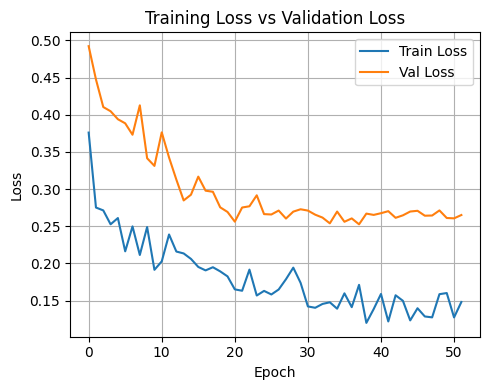

In [5]:
results = main_train(
    mains_train, target_train,
    mains_val, target_val,
    win_len=WIN_LEN, batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, kind=BACKBONE_KIND,
    patience=PATIENCE, min_delta=MIN_DELTA
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("sgn_best.pt", map_location=device)  # small fix: map to the same device
model = SGN(in_ch=1, hid=64, kind="tcn", out_len=1).to(device)
model.load_state_dict(ckpt["model"])
stats = ckpt["stats"]

power_w, reg_w, cls_p = infer_seq2point_timeline_all(model, mains_test, stats, device)
y_true = target_test  # watts


In [ ]:
def smape(a, f):
    denom = (np.abs(a) + np.abs(f)).clip(1e-6, None)
    return (100.0 / len(a)) * np.sum(np.abs(f - a) / denom)

mae_w = np.mean(np.abs(power_w - y_true))
energy_true = y_true.sum()
energy_pred = power_w.sum()
sae = np.abs(energy_pred - energy_true) / (energy_true + 1e-6)
smape_val = smape(y_true, power_w)

print(f"House2 {APPLIANCE_COL} | Test MAE (W): {mae_w:.2f}")
print(f"SAE (energy rel. error): {sae:.4f}")
print(f"sMAPE (%): {smape_val:.2f}")


House2 Appliance2 | Test MAE (W): 9.73
SAE (energy rel. error): 0.8011
sMAPE (%): 95.36


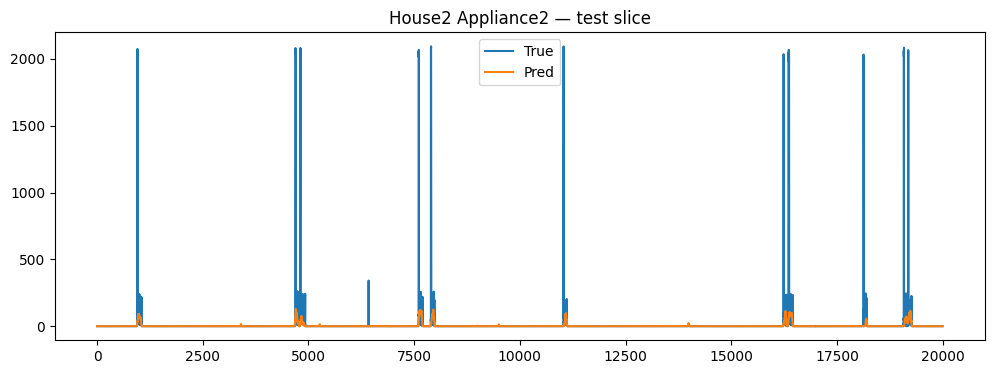

In [ ]:
N = min(20000, len(y_true))
plt.figure(figsize=(12,4))
plt.plot(y_true[:N], label="True")
plt.plot(power_w[:N], label="Pred (Gated Power)")
plt.legend()
plt.title(f"House2 {APPLIANCE_COL} — test slice")
plt.show()


In [ ]:
N = min(20000, len(y_true))


on_threshold = 15.0
true_cls = (y_true[:N] > on_threshold).astype(float)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)


ax1.plot(y_true[:N], label="True Power", color="black")
ax1.plot(reg_w[:N], label="Regression Output (W)", color="tab:blue")
ax1.set_ylabel("Power (W)")
ax1.set_title(f"House2 {APPLIANCE_COL} — Regression vs True")
ax1.legend()


ax2.plot(true_cls, label="True ON/OFF", color="black", linestyle="--")
ax2.plot(cls_p[:N], label="Predicted ON Probability", color="tab:red")
ax2.set_ylabel("ON Probability")
ax2.set_xlabel("Timestep")
ax2.set_ylim(-0.05, 1.05)
ax2.set_title(f"House2 {APPLIANCE_COL} — Classification vs True")
ax2.legend()

plt.tight_layout()
plt.show()